<a href="https://colab.research.google.com/github/CassioSStella/AnaliseFaltaSim-trica/blob/main/TrabPot2Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------
    Análise de Faltas Simétricas
------------------------------------------------------------

=== ENTRADA DE DADOS DO SISTEMA ===

Número de barras do sistema: 8
Número de linhas de transmissão: 9

Insira os dados das 9 linhas de transmissão:
Formato: Barra_origem Barra_destino Resistência(pu) Reatância(pu)
Linha 1: 3 8 0 0.1899
Linha 2: 5 6 0 0.1089
Linha 3: 2 4 0.1730
Erro: Insira exatamente 4 valores (barra_origem barra_destino R X)
Linha 3: 2 4 0 0.1730
Linha 4: 2 5 0.1834
Erro: Insira exatamente 4 valores (barra_origem barra_destino R X)
Linha 4: 2 5 0 0.1830
Linha 5: 1 7 0.2085
Erro: Insira exatamente 4 valores (barra_origem barra_destino R X)
Linha 5: 1 7 0 0.2085
Linha 6: 2 6 0 0.2731
Linha 7: 1 4 0 0.1246
Linha 8: 5 8 0 0.1909
Linha 9: 5 7 0 0.1821

Insira as reatâncias dos geradores para as 8 barras:
(Digite 'inf' ou um valor muito grande se não houver gerador na barra)
Reatância do gerador na barra 1 (pu): 0.2310


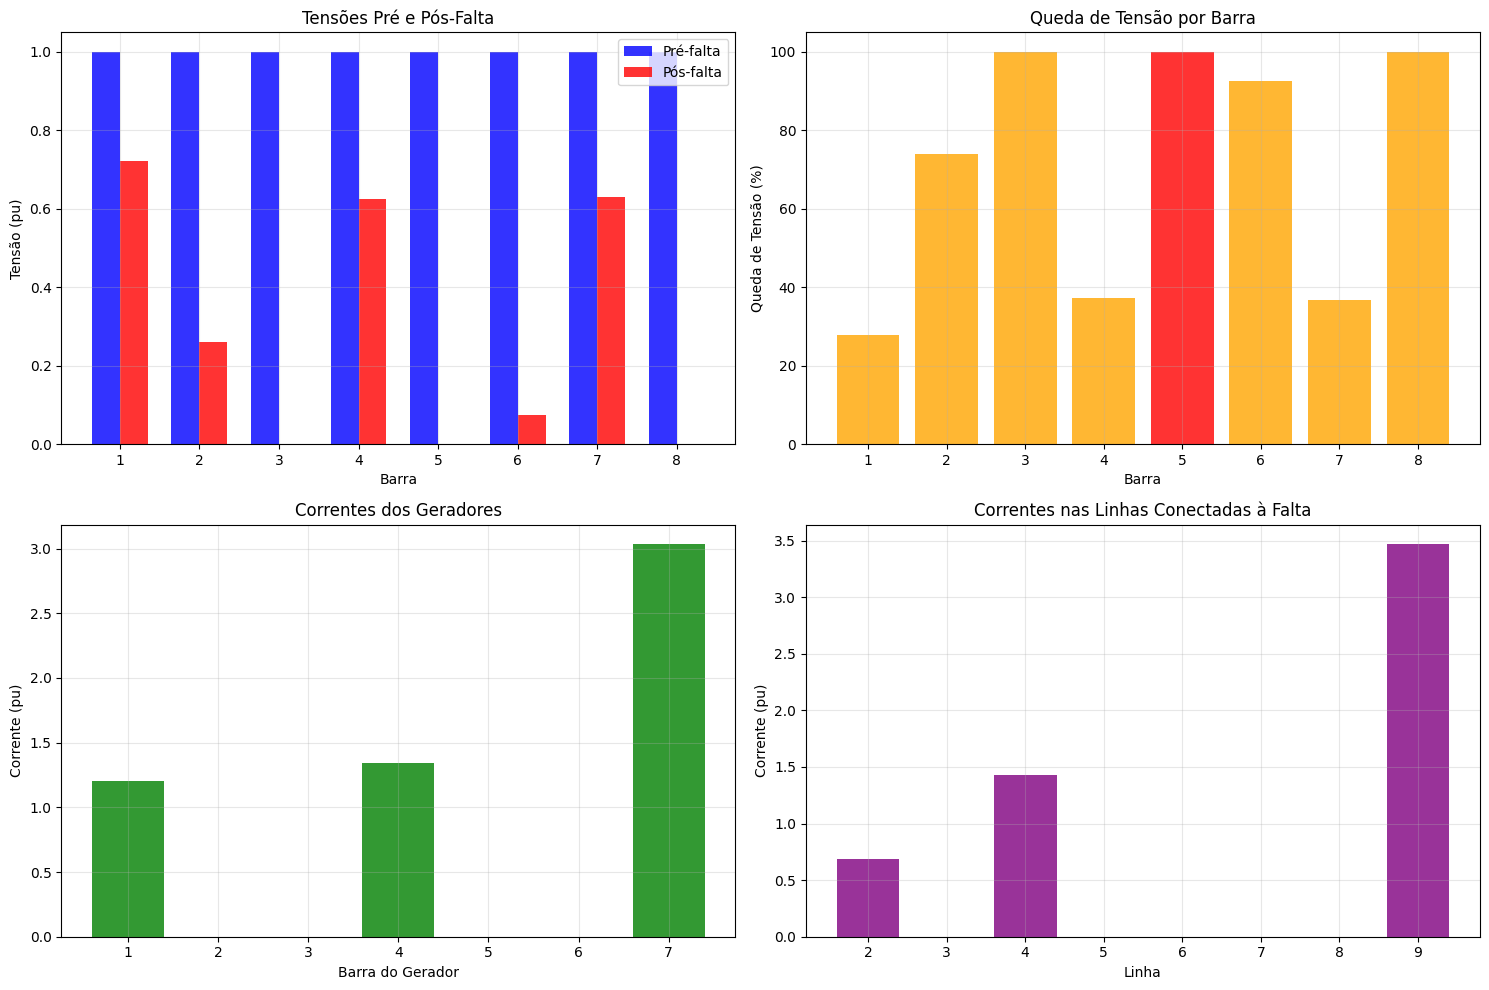

KeyboardInterrupt: Interrupted by user

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

def get_system_data():
    """
    Coleta os dados do sistema elétrico de potência do usuário
    """
    print("=== ENTRADA DE DADOS DO SISTEMA ===")
    print()

    # Número de barras
    while True:
        try:
            nb = int(input("Número de barras do sistema: "))
            if nb > 0:
                break
            else:
                print("Número de barras deve ser maior que zero.")
        except ValueError:
            print("Por favor, digite um número inteiro válido.")

    # Número de linhas
    while True:
        try:
            nl = int(input("Número de linhas de transmissão: "))
            if nl > 0:
                break
            else:
                print("Número de linhas deve ser maior que zero.")
        except ValueError:
            print("Por favor, digite um número inteiro válido.")

    # Dados das linhas
    print(f"\nInsira os dados das {nl} linhas de transmissão:")
    print("Formato: Barra_origem Barra_destino Resistência(pu) Reatância(pu)")
    linhas = []

    for i in range(nl):
        while True:
            try:
                linha_str = input(f"Linha {i+1}: ")
                dados = linha_str.split()
                if len(dados) != 4:
                    print("Erro: Insira exatamente 4 valores (barra_origem barra_destino R X)")
                    continue

                barra_de = int(dados[0])
                barra_para = int(dados[1])
                R = float(dados[2])
                X = float(dados[3])

                if barra_de < 1 or barra_de > nb or barra_para < 1 or barra_para > nb:
                    print(f"Erro: Barras devem estar entre 1 e {nb}")
                    continue

                if barra_de == barra_para:
                    print("Erro: Barra de origem deve ser diferente da barra de destino")
                    continue

                linhas.append([barra_de, barra_para, R, X])
                break

            except ValueError:
                print("Erro: Valores inválidos. Use números inteiros para barras e números reais para R e X.")

    linhas = np.array(linhas)

    # Reatâncias dos geradores
    print(f"\nInsira as reatâncias dos geradores para as {nb} barras:")
    print("(Digite 'inf' ou um valor muito grande se não houver gerador na barra)")

    Xg = []
    for i in range(nb):
        while True:
            try:
                xg_str = input(f"Reatância do gerador na barra {i+1} (pu): ")
                if xg_str.lower() in ['inf', 'infinito', 'infinity']:
                    Xg.append(np.inf)
                    break
                else:
                    xg_val = float(xg_str)
                    if xg_val <= 0:
                        print("Reatância deve ser positiva.")
                        continue
                    Xg.append(xg_val)
                    break
            except ValueError:
                print("Valor inválido. Digite um número positivo ou 'inf'.")

    Xg = np.array(Xg)

    # Tensões pré-falta
    print(f"\nInsira as tensões pré-falta para as {nb} barras:")
    print("(Pressione Enter para usar 1.0 pu para todas as barras)")

    tensoes_input = input("Tensões pré-falta separadas por espaço (ou Enter para padrão): ").strip()

    if tensoes_input:
        try:
            tensoes = [float(x) for x in tensoes_input.split()]
            if len(tensoes) != nb:
                print(f"Aviso: Esperado {nb} tensões, usando 1.0 pu para todas as barras.")
                Vpref = np.ones(nb, dtype=complex)
            else:
                Vpref = np.array(tensoes, dtype=complex)
        except ValueError:
            print("Erro nos valores de tensão, usando 1.0 pu para todas as barras.")
            Vpref = np.ones(nb, dtype=complex)
    else:
        Vpref = np.ones(nb, dtype=complex)

    return nb, nl, linhas, Xg, Vpref

def analyze_symmetric_fault():
    """
    Análise de Faltas Simétricas
    """

    # Cabeçalho
    print('-' * 60)
    print('    Análise de Faltas Simétricas')
    print('-' * 60)
    print()

    # Obter dados do sistema
    nb, nl, linhas, Xg, Vpref = get_system_data()

    # Escolha da barra de falta
    print(f"\n=== SELEÇÃO DA BARRA DE FALTA ===")
    while True:
        try:
            bf = int(input(f'Informe a barra em falta (1 a {nb}): '))
            if bf in range(1, nb + 1):
                break
            else:
                print(f'Barra inválida. Escolha um valor entre 1 e {nb}.')
        except ValueError:
            print('Por favor, digite um número inteiro.')

    # Conversão para índice base 0 (Python)
    bf_idx = bf - 1

    print(f"\n=== RESULTADOS DA ANÁLISE ===")
    print()

    # 1. Montagem da Matriz Ybus
    Ybus = np.zeros((nb, nb), dtype=complex)

    for k in range(nl):
        m = int(linhas[k, 0]) - 1  # Conversão para índice base 0
        n = int(linhas[k, 1]) - 1  # Conversão para índice base 0
        R = linhas[k, 2]  # Resistência R da linha
        X = linhas[k, 3]  # Reatância X da linha

        z = R + 1j * X  # Impedância complexa da linha z = R + jX
        y = 1 / z       # Admitância complexa da linha y = 1/z

        Ybus[m, m] += y
        Ybus[n, n] += y
        Ybus[m, n] -= y
        Ybus[n, m] -= y

    # Adiciona as admitâncias dos geradores na diagonal principal da Ybus
    for b in range(nb):
        if not np.isinf(Xg[b]):
            Ybus[b, b] += 1 / (1j * Xg[b])

    print('Matriz Ybus (Matriz Admitância de Barra):')
    print_complex_matrix(Ybus)
    print()

    # 2. Cálculo da Matriz Zbus
    Zbus = np.linalg.inv(Ybus)
    print('Matriz Zbus (Matriz Impedância de Barra):')
    print_complex_matrix(Zbus)
    print()

    # 3. Corrente de falta na barra de falta
    If = Vpref[bf_idx] / Zbus[bf_idx, bf_idx]
    print(f'Corrente de falta na barra {bf}: {abs(If):.4f} ∠{np.angle(If, deg=True):.2f}° pu')
    print()

    # 4. Tensões pós-falta em todas as barras
    print('Tensões pós-falta (pu):')
    print('-' * 30)

    V_posfalta = Vpref - Zbus[:, bf_idx] * If
    for b in range(nb):
        print(f' Barra {b+1}: {abs(V_posfalta[b]):.4f} ∠{np.angle(V_posfalta[b], deg=True):.2f}°')
    print()

    # 5. Contribuição dos Geradores para a Corrente de Falta
    print('Contribuições individuais dos geradores para a corrente de falta (pu):')
    print('-' * 75)

    generator_currents = {}
    for b in range(nb):
        if not np.isinf(Xg[b]):
            Zg = 1j * Xg[b]
            Ig = (Vpref[b] - V_posfalta[b]) / Zg
            generator_currents[b+1] = Ig
            print(f' Gerador na barra {b+1}: {abs(Ig):.4f} ∠{np.angle(Ig, deg=True):.2f}° pu')

    if not generator_currents:
        print(" Nenhum gerador encontrado no sistema.")
    print()

    # 6. Correntes nas linhas conectadas à barra de falta
    print(f'Correntes nas linhas conectadas à barra de falta {bf} (pu):')
    print('-' * 60)

    fault_connected_lines = {}
    for k in range(nl):
        m = int(linhas[k, 0]) - 1
        n = int(linhas[k, 1]) - 1

        # Verifica se a linha está conectada à barra de falta
        if m == bf_idx or n == bf_idx:
            R = linhas[k, 2]
            X = linhas[k, 3]
            zlt = R + 1j * X

            # Calcula corrente na direção da barra de falta
            if m == bf_idx:
                # Corrente fluindo de n para m (direção da falta)
                Ilt = (V_posfalta[n] - V_posfalta[m]) / zlt
                direction = f"{n+1}→{m+1}"
            else:
                # Corrente fluindo de m para n (direção da falta)
                Ilt = (V_posfalta[m] - V_posfalta[n]) / zlt
                direction = f"{m+1}→{n+1}"

            fault_connected_lines[k+1] = Ilt
            print(f' Linha {int(linhas[k, 0])}–{int(linhas[k, 1])} ({direction}): {abs(Ilt):.4f} ∠{np.angle(Ilt, deg=True):.2f}° pu')

    if not fault_connected_lines:
        print(" Nenhuma linha conectada à barra de falta.")
    print()

    # 7. Correntes em todas as linhas (informação adicional)
    print('Correntes em todas as linhas de transmissão (pós-falta) (pu):')
    print('-' * 60)

    all_line_currents = {}
    for k in range(nl):
        m = int(linhas[k, 0]) - 1
        n = int(linhas[k, 1]) - 1
        R = linhas[k, 2]
        X = linhas[k, 3]

        zlt = R + 1j * X
        Ilt = (V_posfalta[m] - V_posfalta[n]) / zlt
        all_line_currents[k+1] = Ilt

        print(f' Linha {int(linhas[k, 0])}–{int(linhas[k, 1])}: {abs(Ilt):.4f} ∠{np.angle(Ilt, deg=True):.2f}° pu')
    print()

    # Verificação das contribuições dos geradores
    if generator_currents:
        print('Verificação das contribuições dos geradores:')
        print('-' * 45)
        total_gen_current = sum(generator_currents.values())
        print(f'Soma das correntes dos geradores: {abs(total_gen_current):.4f} ∠{np.angle(total_gen_current, deg=True):.2f}° pu')
        print(f'Corrente de falta: {abs(If):.4f} ∠{np.angle(If, deg=True):.2f}° pu')
        print(f'Diferença: {abs(abs(total_gen_current) - abs(If)):.6f} pu')
        print()

    # Retorna os resultados
    return {
        'num_buses': nb,
        'num_lines': nl,
        'fault_bus': bf,
        'fault_current': If,
        'fault_impedance': Zbus[bf_idx, bf_idx],
        'prefault_voltages': Vpref,
        'postfault_voltages': V_posfalta,
        'generator_currents': generator_currents,
        'fault_connected_line_currents': fault_connected_lines,
        'all_line_currents': all_line_currents,
        'Ybus': Ybus,
        'Zbus': Zbus,
        'lines': linhas,
        'generator_reactances': Xg
    }

def print_complex_matrix(matrix, precision=4):
    """
    Imprime uma matriz complexa de forma organizada com alinhamento automático

    Args:
        matrix: Matriz NumPy com números complexos
        precision: Número de casas decimais para exibição (padrão: 4)

    Funcionamento:
        1. Primeira passagem: Percorre todos os elementos da matriz para determinar
           a largura máxima necessária para formatação uniforme
        2. Segunda passagem: Imprime a matriz com alinhamento à direita usando
           a largura máxima encontrada
    """
    rows, cols = matrix.shape

    # PRIMEIRA PASSAGEM: Determina a largura máxima necessária para formatação
    # Percorre todos os elementos da matriz para encontrar o texto mais longo
    max_width = 0
    for i in range(rows):
        for j in range(cols):
            val = matrix[i, j]

            # Verifica se o valor é puramente real (parte imaginária = 0)
            if np.isreal(val) and np.imag(val) == 0:
                # Formata apenas a parte real
                text = f"{np.real(val):.{precision}f}"
            else:
                # Formata como número complexo (a+bj ou a-bj)
                real_part = np.real(val)
                imag_part = np.imag(val)

                # Controla o sinal da parte imaginária
                if imag_part >= 0:
                    text = f"{real_part:.{precision}f}+{imag_part:.{precision}f}j"
                else:
                    # Para números negativos, o sinal já está incluso no valor
                    text = f"{real_part:.{precision}f}{imag_part:.{precision}f}j"

            # Atualiza a largura máxima encontrada
            max_width = max(max_width, len(text))

    # SEGUNDA PASSAGEM: Imprime a matriz com formatação alinhada
    # Constrói cada linha da matriz com alinhamento à direita
    for i in range(rows):
        row_str = "["  # Inicia a linha com colchete

        for j in range(cols):
            val = matrix[i, j]

            # Repete a mesma lógica de formatação da primeira passagem
            if np.isreal(val) and np.imag(val) == 0:
                text = f"{np.real(val):.{precision}f}"
            else:
                real_part = np.real(val)
                imag_part = np.imag(val)
                if imag_part >= 0:
                    text = f"{real_part:.{precision}f}+{imag_part:.{precision}f}j"
                else:
                    text = f"{real_part:.{precision}f}{imag_part:.{precision}f}j"

            # Adiciona o elemento formatado com alinhamento à direita
            row_str += f"{text:>{max_width}}"

            # Adiciona espaçamento entre colunas (exceto na última coluna)
            if j < cols - 1:
                row_str += "  "

        row_str += "]"  # Fecha a linha com colchete
        print(row_str)


def plot_results(results):
    """
    Plota os resultados da análise de curto-circuito
    """
    nb = results['num_buses']
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Gráfico 1: Tensões pré e pós-falta
    bus_numbers = list(range(1, nb + 1))
    v_pre = [abs(v) for v in results['prefault_voltages']]
    v_post = [abs(v) for v in results['postfault_voltages']]

    x = np.arange(len(bus_numbers))
    width = 0.35

    ax1.bar(x - width/2, v_pre, width, label='Pré-falta', alpha=0.8, color='blue')
    ax1.bar(x + width/2, v_post, width, label='Pós-falta', alpha=0.8, color='red')
    ax1.set_xlabel('Barra')
    ax1.set_ylabel('Tensão (pu)')
    ax1.set_title('Tensões Pré e Pós-Falta')
    ax1.set_xticks(x)
    ax1.set_xticklabels(bus_numbers)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Queda de tensão
    voltage_drop = [(v_pre[i] - v_post[i]) * 100 for i in range(len(bus_numbers))]
    colors = ['red' if bus == results['fault_bus'] else 'orange' for bus in bus_numbers]

    ax2.bar(bus_numbers, voltage_drop, alpha=0.8, color=colors)
    ax2.set_xlabel('Barra')
    ax2.set_ylabel('Queda de Tensão (%)')
    ax2.set_title('Queda de Tensão por Barra')
    ax2.grid(True, alpha=0.3)

    # Gráfico 3: Correntes dos geradores
    if results['generator_currents']:
        gen_buses = list(results['generator_currents'].keys())
        gen_currents = [abs(results['generator_currents'][bus]) for bus in gen_buses]

        ax3.bar(gen_buses, gen_currents, alpha=0.8, color='green')
        ax3.set_xlabel('Barra do Gerador')
        ax3.set_ylabel('Corrente (pu)')
        ax3.set_title('Correntes dos Geradores')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Nenhum gerador no sistema',
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Correntes dos Geradores')

    # Gráfico 4: Correntes nas linhas conectadas à falta
    if results['fault_connected_line_currents']:
        line_numbers = list(results['fault_connected_line_currents'].keys())
        line_currents = [abs(results['fault_connected_line_currents'][line]) for line in line_numbers]

        ax4.bar(line_numbers, line_currents, alpha=0.8, color='purple')
        ax4.set_xlabel('Linha')
        ax4.set_ylabel('Corrente (pu)')
        ax4.set_title('Correntes nas Linhas Conectadas à Falta')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Nenhuma linha conectada à falta',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correntes nas Linhas Conectadas à Falta')

    plt.tight_layout()
    plt.show()

def export_to_csv(results, filename='fault_analysis_results.csv'):
    """
    Exporta os resultados para arquivo CSV
    """
    data = []

    # Dados das barras
    for i in range(results['num_buses']):
        bus_num = i + 1
        v_pre = results['prefault_voltages'][i]
        v_post = results['postfault_voltages'][i]

        data.append({
            'Tipo': 'Barra',
            'Número': bus_num,
            'Descrição': f'Barra_{bus_num}',
            'Tensão_Pré_Magnitude': abs(v_pre),
            'Tensão_Pré_Ângulo': np.angle(v_pre, deg=True),
            'Tensão_Pós_Magnitude': abs(v_post),
            'Tensão_Pós_Ângulo': np.angle(v_post, deg=True),
            'Queda_Tensão_Percentual': (abs(v_pre) - abs(v_post)) * 100,
            'Corrente_Magnitude': None,
            'Corrente_Ângulo': None
        })

    # Dados dos geradores
    for bus_num, current in results['generator_currents'].items():
        data.append({
            'Tipo': 'Gerador',
            'Número': bus_num,
            'Descrição': f'Gerador_Barra_{bus_num}',
            'Tensão_Pré_Magnitude': None,
            'Tensão_Pré_Ângulo': None,
            'Tensão_Pós_Magnitude': None,
            'Tensão_Pós_Ângulo': None,
            'Queda_Tensão_Percentual': None,
            'Corrente_Magnitude': abs(current),
            'Corrente_Ângulo': np.angle(current, deg=True)
        })

    # Dados das linhas conectadas à falta
    for line_num, current in results['fault_connected_line_currents'].items():
        line_data = results['lines'][line_num - 1]
        from_bus = int(line_data[0])
        to_bus = int(line_data[1])

        data.append({
            'Tipo': 'Linha_Falta',
            'Número': line_num,
            'Descrição': f'Linha_{from_bus}_to_{to_bus}_Falta',
            'Tensão_Pré_Magnitude': None,
            'Tensão_Pré_Ângulo': None,
            'Tensão_Pós_Magnitude': None,
            'Tensão_Pós_Ângulo': None,
            'Queda_Tensão_Percentual': None,
            'Corrente_Magnitude': abs(current),
            'Corrente_Ângulo': np.angle(current, deg=True)
        })

    # Dados de todas as linhas
    for line_num, current in results['all_line_currents'].items():
        line_data = results['lines'][line_num - 1]
        from_bus = int(line_data[0])
        to_bus = int(line_data[1])

        data.append({
            'Tipo': 'Linha_Todas',
            'Número': line_num,
            'Descrição': f'Linha_{from_bus}_to_{to_bus}_Todas',
            'Tensão_Pré_Magnitude': None,
            'Tensão_Pré_Ângulo': None,
            'Tensão_Pós_Magnitude': None,
            'Tensão_Pós_Ângulo': None,
            'Queda_Tensão_Percentual': None,
            'Corrente_Magnitude': abs(current),
            'Corrente_Ângulo': np.angle(current, deg=True)
        })

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f'Resultados exportados para {filename}')

def main():
    """
    Função principal para executar a análise de curto-circuito
    """
    try:
        # Executa a análise
        results = analyze_symmetric_fault()

        # Pergunta se deseja plotar gráficos
        plot_choice = input('\nDeseja plotar os gráficos? (s/n): ').lower().strip()
        if plot_choice in ['s', 'sim', 'y', 'yes']:
            plot_results(results)

        # Pergunta se deseja exportar para CSV
        export_choice = input('\nDeseja exportar os resultados para CSV? (s/n): ').lower().strip()
        if export_choice in ['s', 'sim', 'y', 'yes']:
            filename = input('Nome do arquivo (pressione Enter para usar o padrão): ').strip()
            if not filename:
                filename = 'fault_analysis_results.csv'
            export_to_csv(results, filename)

        return results

    except Exception as e:
        print(f'\nErro durante a execução: {e}')
        return None

if __name__ == "__main__":
    results = main()